### **Title**

**Introduction**

A research group in Computer Science at UBC is collecting data on how people play video games. Many players were recruited, and many kinds of information about them were recorded as they navigated through a MineCraft server set up by the research group. 
One of the broad questions explored by this study is "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

To further investigate the variables most suited for this purpose, we proposed the question, "Can the variables Age and played_hours work accurately to predict whether a person is or isn't subscribed to game-related newsletters in the game dataset?"

To answer this question, we will be using the players.csv dataset. This dataset contains seven columns with 195 observations of player-specific information. 

The seven columns are:
1. hashedEmail (character)
   - the email/username of each person
   
2. experience (character)
   - Classification of the player type by experience
   - ordered: Beginner, Amateur, Regular, Pro, Veteran

3. subscribe (logical)
   - whether they are subscribed for newsletters or not

4. Name (character)
   - Name of each person participating

5. played_hours (double precision)
   - The total time the player has spent in the game (in hours)

6. gender (character)
   - The gender of the people participating

7. Age (double precision)
   - The age of each person participating

**Methods**

The code will start by loading the players.csv data and naming is players. Next, since we will be focusing on the Age, played hours, and the subscribe variables, we will remove all the NAs from the Age column and change subscribe into factors.

The data analysis will start with splitting the players dataset into 75% for the training and 25% for the testing. The testing will be put aside for now while we create a Knn-classification algorithm with the training set. The set.seed function will be used for this cell and the following cells that are necessary to get the same reproducible results each time. Since K-nearest neighbours is sensitive to the scale of the predictors, the data will be standardized when making the recipe. Next, a K-nearest neighbour model specification will be made, but the neighbour's argument will have tune() instead of a number to find the best K value. A simple tibble will be made to list the K values we will be testing (1 to 10), and the vfold_cv function will be used to perform a five cross-validation later on. After this, a workflow analysis will be made that combines the recipe and the model specification. The tune_grid function will be used instead of fit. The tibble and the cross-validation argument from earlier will be put inside. Lastly, we will use the function collect_metrics to aggregate the mean and standard error.

Now that we have the metrics for each K value, we will filter accuracy from the .metric column and make a line plot with accuracy on the y-axis and the K values on the x-axis. Using the most accurate K, we will make a new K-nearest neighbour model specification and a workflow while still using the training set in the fit function. 

Next, we will assess the algorithm with the testing set. Predictions will be made using the predict and bind_cols function. The output will be put into the metrics function, then the accuracy will be filtered again. Lastly, this output will be put into two functions separately, precision and recall, to determine will the results are satisfactory.

A visualization is also made using the Age as the x-axis, the played_hours as the y-axis, and the subscription for colours from the original players dataset for a scatter plot. 

Below, we will perform the analysis. At the top of each code cell will be a comment explaining what is being accomplished in the cell. For operations involving generating randomness, a seed is set beforehand to ensure reproducibility. 

In [2]:
# Loading in the relevant R packages for answering our question
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
# Loading in the players dataset

players_url <- "https://raw.githubusercontent.com/ryan-jleung/DSCI-planning-individual/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Wrangling the players data to isolate the relevant variables, filter out the "NA" responses in the "Age" column, and change the "subscribe" column values to factor rather than logical type

players_data <- players |>
    select(Age, played_hours, subscribe) |>
    filter(!is.na(Age)) |>
    mutate(subscribe = as_factor(subscribe))
    
players_data

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
⋮,⋮,⋮
22,0.3,FALSE
17,0.0,FALSE
17,2.3,FALSE


In [5]:
# Splitting the players data into a training and testing set with a ratio of 75:25, stratifying for the "subscribe" column
set.seed(1234)

players_split <- initial_split(players_data, prop=0.75, strata=subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_train
players_test

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
21,0.0,FALSE
22,0.0,FALSE
17,0.1,FALSE
⋮,⋮,⋮
17,0,TRUE
20,0,TRUE
17,0,TRUE


Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,0.0,FALSE
21,0.1,TRUE
⋮,⋮,⋮
17,0.1,TRUE
44,0.1,TRUE
17,2.3,FALSE


In [6]:
# creating a recipe for data preprocessing using the training data, and standardizing the data

players_recipe <- recipe(subscribe ~ Age + played_hours, data=players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [7]:
# Creating the KNN model specification.
# Note: the neighbors parameter is set to tune() to allow tuning for the best K-value
set.seed(1234)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors=tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [8]:
# Creating a tibble for feasible K-values and setting up 5-fold cross-validation to assess the performance of the model
set.seed(1234)

k_values <- tibble(neighbors=seq(1,15, by=1))
cv_folds <- vfold_cv(players_train, v=5, strata=subscribe)

# k_values
# cv_folds

In [9]:
# Creating a workflow combining the recipe and model specification
# Note: the tune_grid() function is used to perform 5-fold cross-validation to ensure more reliable performance estimates
set.seed(1234)

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cv_folds, grid=k_values) |>
    collect_metrics()

players_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5175205,5,0.03165220,Preprocessor1_Model01
1,roc_auc,binary,0.5337121,5,0.03512980,Preprocessor1_Model01
2,accuracy,binary,0.5034811,5,0.03153583,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.4787376,5,0.04414567,Preprocessor1_Model14
15,accuracy,binary,0.7178161,5,0.01373311,Preprocessor1_Model15
15,roc_auc,binary,0.5181818,5,0.05954431,Preprocessor1_Model15


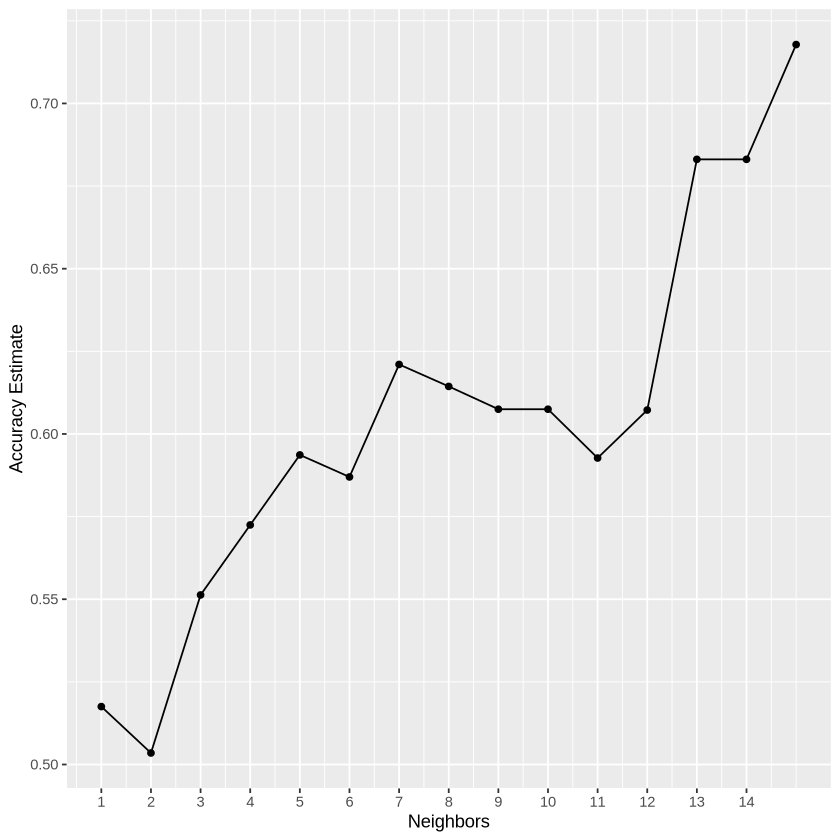

In [10]:
# Filtering for the accuracy metric, and graphing accuracy over K-values 
set.seed(1234)

accuracies <- players_fit |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1))   

accuracy_versus_k

The plot above shows that for the feasible k-values from 1 to 15, K=15 gives us the best accuracy. Cross-validation lets us be sure that this is an unbiased estimate of k by using the average of multiple splits, for each of which there could be a different best k-value depending on exactly what data were in the training vs testing set.

In [11]:
# New model specification and workflow using the most optimal k=15
set.seed(1234)

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_spec) |>
    fit(data = players_train)

In [12]:
# Assessing the model with the testing set
set.seed(1234)

predictions <- predict(final_fit, players_test) |>
    bind_cols(players_test)

predictions|> pull(subscribe) |> levels()
predictions

accuracy_metrics <- predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

precision <- predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

recall <- predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

# confusion matrix
conf_matrix <- conf_mat(predictions, truth = subscribe, estimate = .pred_class)

accuracy_metrics
precision
recall
conf_matrix 

[1] "FALSE" "TRUE"

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
TRUE,9,30.3,TRUE
TRUE,17,0.0,FALSE
TRUE,21,0.1,TRUE
⋮,⋮,⋮,⋮
TRUE,17,0.1,TRUE
FALSE,44,0.1,TRUE
TRUE,17,2.3,FALSE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7234043


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9444444


          Truth
Prediction FALSE TRUE
     FALSE     0    2
     TRUE     13   34

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


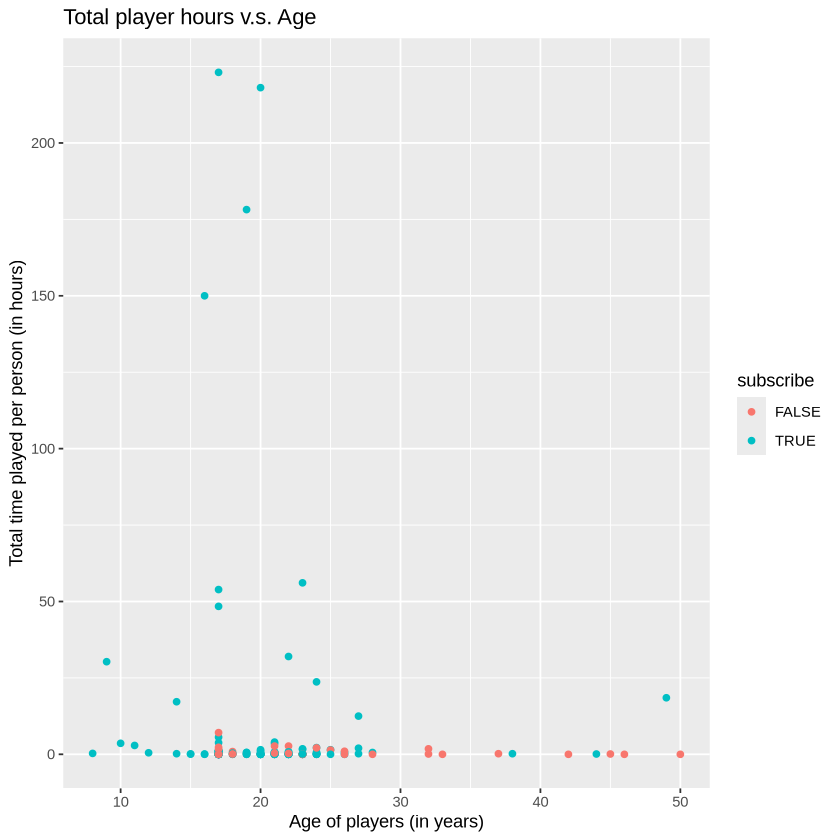

In [14]:
#Creating a visualization using the original players dataset out of the variables of interest
subscription_plot<-ggplot(players, aes(x=Age, y=played_hours, color=subscribe))+
    geom_point()+
    labs(x="Age of players (in years)", y="Total time played per person (in hours)", title="Total player hours v.s. Age")
subscription_plot

**Results**

|   |Accuracy|Precision|Recall|
|---|---|-------------|---|
|.estimates|0.6938776|0.7234043|0.9444444|

As seen from the table above, the trained algorithm showed an accuracy of 0.6938776, a precision of 0.7234043, and a recall of 0.9444444. 

**Discusssion**

